In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pypsa
from IPython.utils.io import capture_output

import sys
sys.path.append(str(Path.cwd().parent / 'scripts'))
from _helpers import to_datetime, to_date_period

In [2]:
path = Path.cwd().parent / 'data'

In [3]:
gen = pd.read_csv('gen_2024.csv', index_col=0, parse_dates=True)

In [4]:
carrier_mapper = {
    "PHS": "hydro",
    "hydro-scheme": "hydro",
    "hydro": "hydro",
    "dam": "hydro",
    "PHS": "hydro",
    "floating wind": "wind",
    "onwind": "wind",
    "wind": "wind",
    "offwind": "wind",
    "CCGT": "gas",
    "CHP": "gas",
    "biomass": "biomass",
    "gas": "gas",
    "gas-fired": "gas",
    "gas turbine": "gas",
    "coal": "coal",
    "powerstation": "gas",
    "cascade": "gas",
    "nuclear": "nuclear",
    "battery": "battery",
    'interconnector': 'imports',
    'PV': 'solar',
    'solar power station': 'solar',
}

In [5]:
import os
from tqdm import tqdm

start, end = '2024-03-01', '2024-03-31'

def get_mix(day, period):

    if isinstance(day, pd.Timestamp):
        day = day.strftime('%Y-%m-%d')

    try:
        # with contextlib.redirect_stdout(None):

        with capture_output() as c:

            n = pypsa.Network(
                Path.cwd().parent /
                'resources' /
                'live_data' /
                f'{day}_{period}' /
                'network_s_nodal_solved.nc'
                )
    except FileNotFoundError:
        return pd.Series()

    gen = pd.concat((
        n.generators['carrier'],
        n.generators_t.p.iloc[0].rename('dispatch')
    ), axis=1).groupby('carrier').sum()

    mix = pd.Series(0, np.unique(list(carrier_mapper.values())))

    d = gen.index.difference(list(carrier_mapper))
    if len(d) > 0:
        print(d)
        raise KeyError

    for model_carrier, clean in carrier_mapper.items():

        try:
            mix.loc[clean] += gen.loc[model_carrier, 'dispatch']
        except KeyError:
            continue

    return mix.rename(to_datetime(day, period))

from itertools import product

days = pd.date_range(start, '2024-03-31')

mix = pd.concat((
    get_mix(day, p) for day, p in tqdm(product(days, range(1, 49)))
), axis=1).dropna(axis=1).T


1488it [09:36,  2.58it/s]


In [6]:

hold = mix.copy()
hold.index = pd.to_datetime(hold.index).tz_localize('UTC')

dt = hold.index[0]
hold.drop(columns=['battery', 'solar'], inplace=True)

In [7]:
gen.columns

Index(['GAS', 'COAL', 'NUCLEAR', 'WIND', 'HYDRO', 'IMPORTS', 'BIOMASS',
       'OTHER', 'SOLAR', 'STORAGE', 'GENERATION', 'CARBON_INTENSITY',
       'LOW_CARBON', 'ZERO_CARBON', 'RENEWABLE', 'FOSSIL', 'GAS_perc',
       'COAL_perc', 'NUCLEAR_perc', 'WIND_perc', 'HYDRO_perc', 'IMPORTS_perc',
       'BIOMASS_perc', 'OTHER_perc', 'SOLAR_perc', 'STORAGE_perc',
       'GENERATION_perc', 'LOW_CARBON_perc', 'ZERO_CARBON_perc',
       'RENEWABLE_perc', 'FOSSIL_perc'],
      dtype='object')

In [8]:
ss = gen.loc[hold.index, hold.columns.str.upper()]
ss.columns = ss.columns.str.lower()

In [9]:
pd.concat((ss.sum().rename('real'), hold.sum().rename('modelled')), axis=1)

,real,modelled
biomass,1269667.0,1.356588e+06
coal,330278.0,5.541638e+05
gas,5886142.0,6.199245e+06
hydro,362989.0,5.227172e+05
imports,4666489.0,3.516881e+06
nuclear,2824949.0,2.885825e+06
wind,8132246.0,6.558927e+06


In [10]:
carrier_colors = {
    "wind": "#7ac677",
    "offshore wind": "#6895dd",
    "hydro": "#0079c1",
    "coal": "#454546",
    "biomass": "#dbc263",
    "gas": "#f6986b",
    "nuclear": '#549ca2',
    "imports": "#dd75b0",
    "cascade": "#46caf0",
    "solar": "#f9d002",
    "battery": '#ace37f',
}

In [11]:
ss.columns
ordered = ['nuclear', 'coal', 'biomass', 'gas', 'imports', 'hydro', 'wind']
ss = ss[ordered]
hold = hold[ordered]

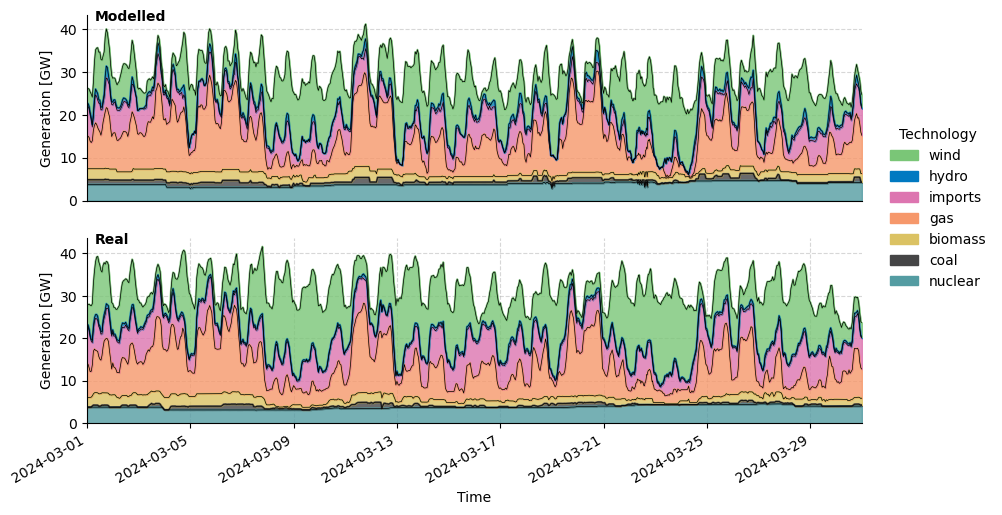

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

area_kwargs = {
    'alpha': 0.8,
    # 'linecolor': 'black',
    # 'linewidth': 0.5
}


hold.clip(lower=0).mul(1e-3).plot.area(ax=axs[0], legend=False, color=[carrier_colors.get(c, 'black') for c in hold.columns], **area_kwargs)
hold.clip(lower=0).cumsum(axis=1).mul(1e-3).plot(ax=axs[0], legend=False, color='k', linewidth=0.5)

ss.mul(1e-3).plot.area(ax=axs[1], legend=False, color=[carrier_colors.get(c, 'black') for c in ss.columns], **area_kwargs)
ss.cumsum(axis=1).mul(1e-3).plot(ax=axs[1], legend=False, color='k', linewidth=0.5)

for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Generation [GW]')
    ax.set_xlim(start, end)

handles, labels = [], []
from matplotlib.patches import Patch

# for carrier, color in carrier_colors.items():
for carrier in ss.columns[::-1]:

    if carrier not in ss.columns:
        continue

    handles.append(Patch(color=carrier_colors[carrier]))
    labels.append(carrier)


axs[0].legend(handles, labels, loc='upper left', bbox_to_anchor=(1.02, 0.46), title='Technology', frameon=False)

axs[0].set_xticks([])
axs[1].set_xlabel('Time')

axs[0].text(0.01, 0.97, 'Modelled', transform=axs[0].transAxes, fontsize=10, fontweight='bold')
axs[1].text(0.01, 0.97, 'Real', transform=axs[1].transAxes, fontsize=10, fontweight='bold')

plt.savefig('real_vs_modelled_energy_mix.png', dpi=300, bbox_inches='tight')
plt.show()